画像の学習において、教師データを用意するのは簡単ではない。ここでは、画像を増やすのに役立つImageDataGeneratorの機能を紹介しよう。

なお、下記の点には注意すること。
* ImageDataGeneratorに入力する画像は0-1の値で正規化しなければならない。ImageDataGeneratorのインスタンスを生成する際の引数rescaleをセットすることで入力画像の値に係数をかけて0-1に調整するか、flow()実行段階で引数に渡す画像が既に0-1に正規化されている必要がある。
* 2018-02-22時点での最新のmatplotlibのimshow()による画像表示では、0-1に正規化された画像でもカラーで表示してくれるが、負値があるとエラーとなる。また、RGBの輝度のスケールが等しければ、0-0.01でのスケールでも表示上は綺麗なカラー画像となる

In [1]:
# 画像の読み込み
from matplotlib import pylab as plt
from keras.utils import np_utils
from PIL import Image
import numpy as np
import os


data_format = "channels_last"


def read_image(dir_name, data_format="channels_last", size=(32, 32), mode="RGB", resize_filter=Image.NEAREST):
    """ 指定されたフォルダ内の画像をリストとして返す
    dir_name: str, フォルダ名、又はフォルダへのパス
    data_format: str, データ構造を指定
    size: tuple<int, int>, 読み込んだ画像のリサイズ後のサイズ
    mode: str, 読み込んだ後の画像の変換モード
    resize_filter: int, Image.NEARESTなど、リサイズに使うフィルターの種類。処理速度が早いやつは粗い
    """
    image_list = []
    files = os.listdir(dir_name)     # ディレクトリ内部のファイル一覧を取得
    print(files)

    for file in files:
        root, ext = os.path.splitext(file)  # 拡張子を取得
        if ext != ".jpg":
            continue

        path = os.path.join(dir_name, file)             # ディレクトリ名とファイル名を結合して、パスを作成
        image = Image.open(path).resize(size, resample=resize_filter)   # 画像の読み込み
        image = image.resize(size, resample=resize_filter)              # 画像のリサイズ
        image = image.convert(mode)                     # 画像のモード変換。　mode=="LA":透過チャンネルも考慮して、グレースケール化, mode=="RGB":Aを無視
        image = np.array(image)                           # ndarray型の多次元配列に変換
        if mode == "RGB" and data_format == "channels_first":
            image = image.transpose(2, 0, 1)    # 配列を変換し、[[Redの配列],[Greenの配列],[Blueの配列]] のような形にする。
        image_list.append(image)                        # 出来上がった配列をimage_listに追加  
    
    return image_list




def preprocessing(imgs):
    """ 画像の前処理
    必要なら呼び出して下さい。
    
    imgs: ndarray, 画像が複数入っている多次元配列
    """
    image_list = []
    
    for img in imgs:
        img2 = (img - np.mean(img)) / np.std(img) / 4 + 0.5   # 平均0.5, 標準偏差を0.25にする
        img2[img2 > 1.0] = 1.0                 # 0-1からはみ出た部分が存在するとImageDataGeneratorに怒られるので、調整
        img2[img2 < 0.0] = 0.0
        
        #img2 = img / 255
        image_list.append(img2)
        
    image_list = np.array(image_list)     # ndarrayに変換
    return image_list


# 画像を読み込む
img1 = read_image('1_test')               # フォルダ内の全画像を読み込む。それぞれの画像は32x32pixelに変換され、1要素が[R,G,B]3要素を含む２次元配列として読み込む。
img2 = read_image('2_test') 
x = np.array(img1 + img2)                 # 型を変換
x = preprocessing(x)                      # 画像の前処理
print(x[0][0][0], np.max(x), np.mean(x), np.min(x), np.std(x))  # チェック（preprocessingの有無の差がわかる）
y = [0] * len(img1) + [1] * len(img2)     # 正解ラベルを作る
y = np_utils.to_categorical(y)            # one-hotencoding
print(x.shape)
print(y)

# 処理が終わった確認のために、時刻を表示
import datetime
print(datetime.datetime.now())

/Users/morishita/.pyenv/versions/3.6.3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['image_0079.jpg', 'image_0078.jpg', 'image_0080.jpg', 'image_0076.jpg', 'image_0077.jpg']
['image_0155.jpg', 'image_0157.jpg', 'image_0156.jpg', 'image_0158.jpg', 'image_0159.jpg', 'image_0160.jpg']
[0.41735706 0.61256288 0.42665257] 1.0 0.49636830844792756 0.0 0.24141559211387234
(11, 32, 32, 3)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
2018-03-21 19:46:45.294517


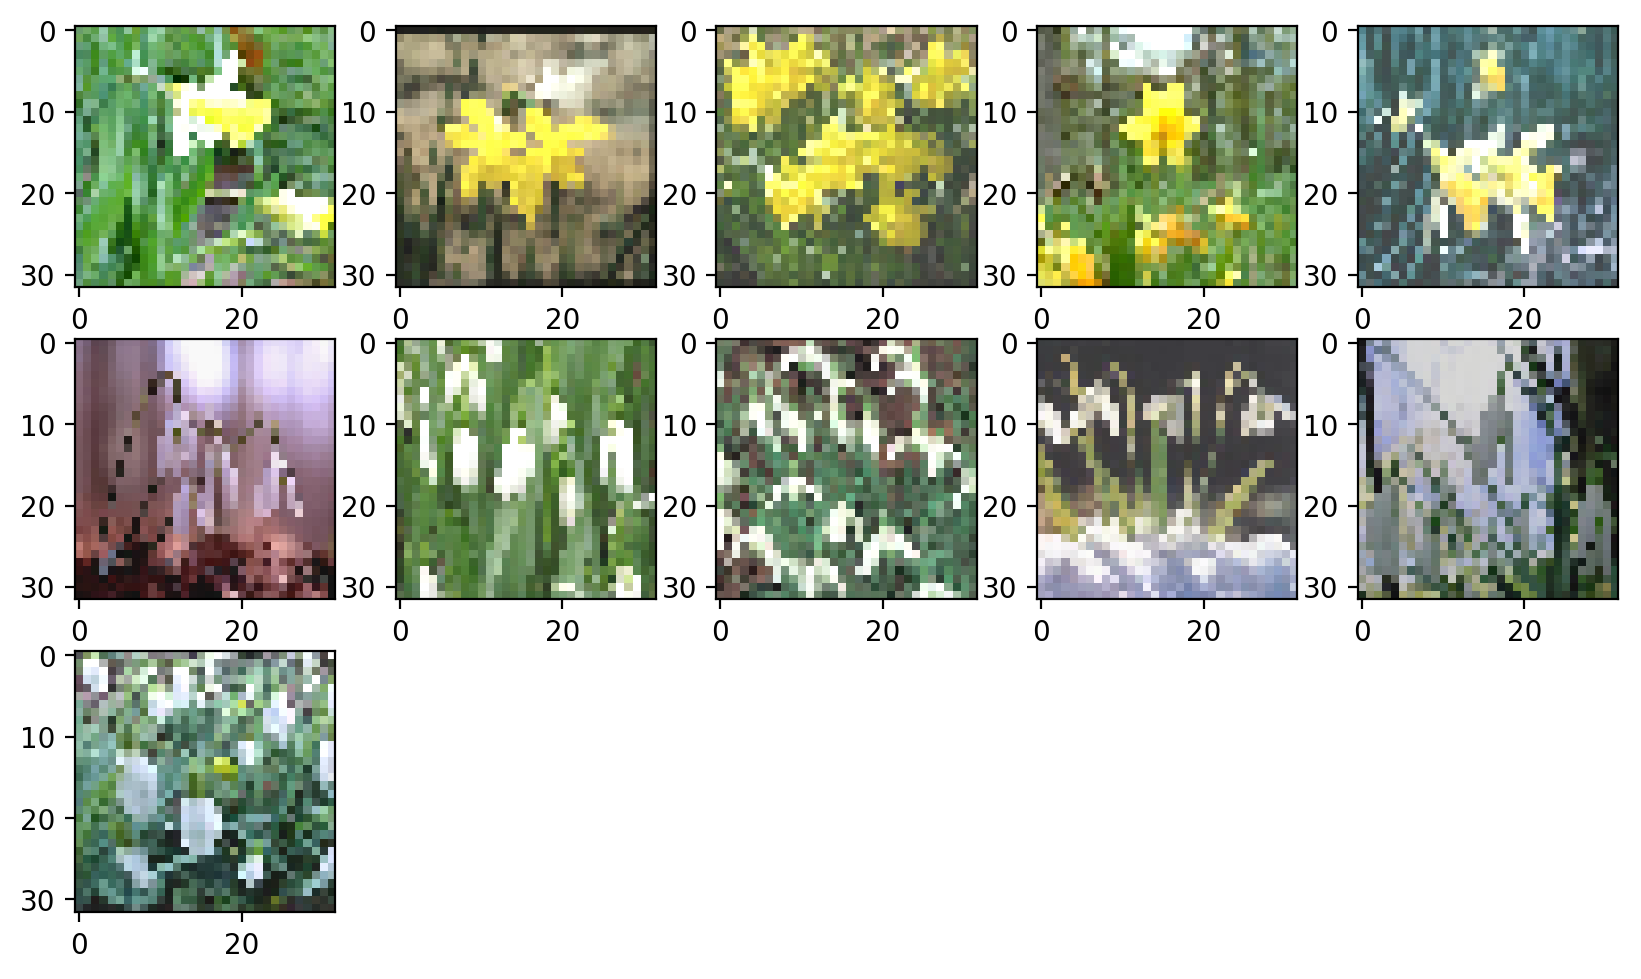

In [2]:
# 確認のために、読み込んだ画像を表示
%matplotlib inline

w = 5    # 横の段数
h = 5     # 縦の段数
plt.figure(figsize=(10,10), dpi=200)    # サイズと解像度を指定

for i in range(len(x)):
    plt.subplot(h, w, i + 1)     # 表示位置を指定
    plt.imshow(x[i])
plt.show()

In [3]:
# 画像を生成するオブジェクトの準備
from keras.preprocessing.image import ImageDataGenerator

# 画像の水増し操作
datagen = ImageDataGenerator(
    #samplewise_center = True,              # 平均をサンプル毎に0
    #samplewise_std_normalization = True,   # 標準偏差をサンプル毎に1に正規化
    #zca_whitening = False,                 # 計算に最も時間がかかる。普段はコメントアウトで良いかも
    rotation_range = 180,                   # 回転角度[degree]
    zoom_range=0.5,                        # 拡大縮小率
    fill_mode='nearest',                    # 引き伸ばしたときの外側の埋め方？
    horizontal_flip=True,                  # 水平方向への反転
    vertical_flip=True,                    # 垂直方向での反転
    rescale=1, # (1/255),                   # flowで受け取った画像の輝度に対する係数で、係数を掛けて取り込む
    width_shift_range=0.3,                  # 横方向のシフト率
    height_shift_range=0.3,                # 縦方向のシフト率
    #data_format=data_format,
    channel_shift_range=0.0,
    )

#  教師データの統計量を内部的に求めるzcaに必要
#datagen.fit(x)

In [9]:
# 教師データを無限に作るオブジェクトを作成
import os 

# フォルダの準備
dir_name = "generated_image"
if os.path.exists(dir_name) == False:
    os.mkdir(dir_name)

# 画像を生成するオブジェクトを作成する。yは省略可能。save_to_dirにフォルダ名をセットすると、生成した画像を保存できる。（はずだが、保存されるのと渡される画像が異なる）
train_gen = datagen.flow(x, y, save_to_dir=dir_name, save_format="jpg", batch_size=5)  #  batch_sizeは1度に生成する画像の数

[0.1026568  0.07059043 0.07415336]


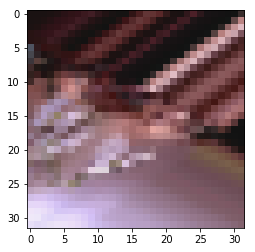

In [10]:
# 1バッチ分の教師データを作成
%matplotlib inline

x_, y_ = train_gen.next()  # 画像生成

# 試しで1つの画素の値を表示
print(x_[0][0][0])

plt.imshow(x_[0])          # 試しに、1つを描画する
plt.show()

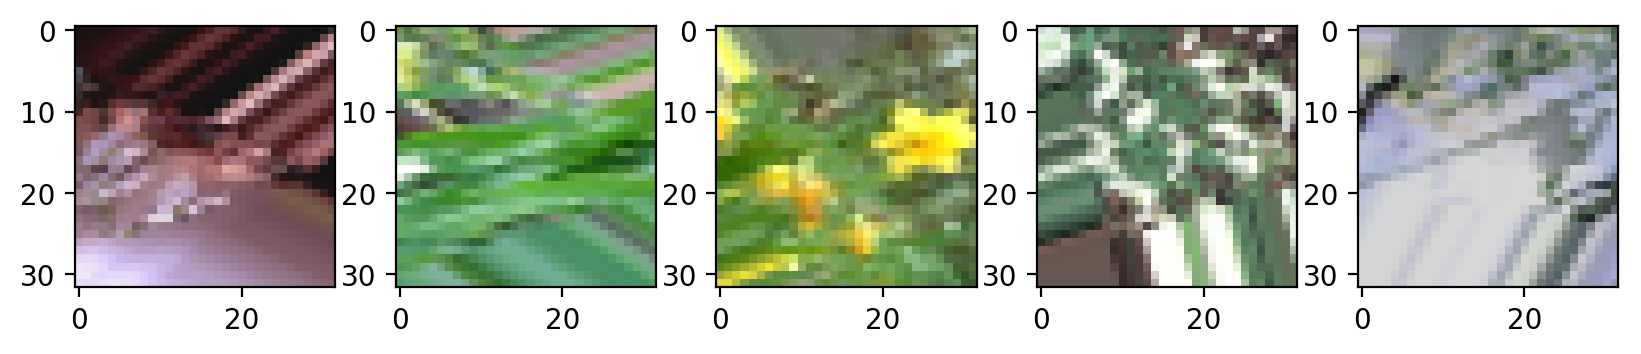

In [11]:
# 全ての生成画像を確認のために表示する
%matplotlib inline

w = 5    # 横の段数
h = 5     # 縦の段数
plt.figure(figsize=(10,10), dpi=200)    # サイズと解像度を指定

for i in range(len(x_)):
    plt.subplot(h, w, i + 1)     # 表示位置を指定
    plt.imshow(x_[i])
plt.show()

In [21]:
# アルゴリズムを考えるための計算欄
# 一様乱数の標準偏差がどの程度か確認
np.std(np.random.rand(1000))

0.2883938367515141